# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plots
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10
from utils.grad_check import gradient_checking

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [4]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    return 0.5*np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1-y_pred) * y.shape[0])
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y*np.log(y_sigmoid) + (1-y)*np.log(1-y_sigmoid))

###### Para Classificação Multiclasse

In [6]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

# Inicialização de Pesos

In [7]:
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # normal com media=0 e stddev=sqrt(2.0 / (out + inp)). Ver notas de np.random.randn.
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev*np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # uniforme de [-limit, limit], onde limit = np.sqrt(6.0 / (out + inp))
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows, cols) - limit

# Regularização

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w > 0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Learning Rate Decay

In [9]:
def none_decay(learning_rate, epoch, decay_rate, decay_step=1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return 1.0 / (1 + decay_rate * epoch)

def exponential_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**epoch

def staircase_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**(epoch // decay_steps)

# Batch Normalization 

In [10]:
def batchnorm_forward(layer, x, is_training=True):
    mu = np.mean(x, axis=0) if is_training else layer._pop_mean
    var = np.var(x, axis=0) if is_training else layer._pop_var
    x_norm = (x - mu) / np.sqrt(var + 1e-8)
    out = layer.gamma * x_norm + layer.beta

    if is_training:
        layer._pop_mean = layer.bn_decay * layer._pop_mean + (1.0-layer.bn_decay)*mu
        layer._pop_var = layer.bn_decay * layer._pop_var + (1.0-layer.bn_decay)*var
        layer._bn_cache = (x, x_norm, mu, var)
    return out

def batchnorm_backward(layer, dactivation):
    x, x_norm, mu, var = layer._bn_cache

    m = layer._activ_inp.shape[0]
    x_mu = x - mu
    std_inv = 1. / np.sqrt(var + 1e-8)

    dx_norm = dactivation * layer.gamma
    dvar = np.sum(dx_norm * x_mu, axis=0) * -0.5 * (std_inv**3)
    dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2.0 * x_mu, axis=0)

    dx = (dx_norm * std_inv) + (dvar * 2.0 * x_mu / m) + (dmu / m)
    layer._dgamma = np.sum(dactivation * x_norm, axis=0)
    layer._dbeta = np.sum(dactivation, axis=0)
    return dx

# Batch Generator

In [11]:
def batch_sequential(x, y, batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size
    
    for batch in range(n_batches):
        offset = batch_size * batch
        x_batch, y_batch = x[offset:offset+batch_size], y[offset:offset+batch_size]
        yield (x_batch, y_batch)
    
def batch_shuffle(x, y, batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

# Implementação 

In [12]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones, dropout_prob=0.0, reg_func=l2_regularization, reg_strength=0.0, batch_norm=False, bn_decay=0.9, is_trainable=True):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.is_trainable = is_trainable
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.gamma, self.beta = ones(1, output_dim), zeros(1, output_dim)  # batch normalization params

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dgamma, self._dbeta = None, None
        self._pop_mean, self._pop_var = zeros(1, output_dim), zeros(1, output_dim)
        self._bn_cache = None
        self._dropout_mask = None

class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, lr_decay_method=none_decay, lr_decay_rate=0.0, lr_decay_steps=1, momentum=0.0, patience=np.inf):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf

    def fit(self, x_train, y_train, x_val=None, y_val=None, epochs=100, verbose=10, batch_gen=batch_sequential, batch_size=None):
        x_val, y_val = (x_train, y_train) if x_val is None or y_val is None else (x_val, y_val)

        for epoch in range(epochs+1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)

            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feedforward(x_batch)
                self.__backprop(y_batch, y_pred)

            data_loss_val = self.cost_func(y_val, self.predict(x_val))
            if data_loss_val < self._best_loss:
                self._best_model, self._best_loss = self.layers, data_loss_val
                self.waiting = 0
            else:
                self.waiting += 1
                if self.waiting >= self.patience:
                    self.layers = self._best_model
                    return

            if epoch % verbose == 0:
                data_loss_train = self.cost_func(y_train, self.predict(x_train))
                reg_loss = (1.0/y_batch.shape[0])*np.sum([layer.reg_strength * layer.reg_func(layer.weights) for layer in self.layers])
                print("epoch: {0:=4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val = {5:.8f}".format(epoch, epochs, data_loss_train, reg_loss, data_loss_train + reg_loss, data_loss_val))

    def predict(self, x):
        return self.__feedforward(x, is_training=False)

    def __feedforward(self, x, is_training=True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            y = batchnorm_forward(current_layer, y, is_training) if current_layer.batch_norm else y
            current_layer._dropout_mask = np.random.binomial(1, 1.0-current_layer.dropout_prob, y.shape) / (1.0-current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out

    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer._dropout_mask
            dactivation = batchnorm_backward(layer, dactivation) if layer.batch_norm else dactivation
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)

        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + (1.0/y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, derivative=True)
                layer._prev_dweights = -self.learning_rate*layer._dweights + self.momentum*layer._prev_dweights
                layer.weights = layer.weights + layer._prev_dweights
                layer.biases = layer.biases - self.learning_rate*layer._dbiases
                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate*layer._dgamma
                    layer.beta = layer.beta - self.learning_rate*layer._dbeta

## Exemplos do Notebook da Intuição

### Exemplo 1

In [13]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 loss_train: 0.14023572 + 0.00000000 = 0.14023572 loss_val = 0.14023572
[[ 0.14978072  0.19956143]
 [ 0.24975114  0.29950229]]
[[ 0.35891648  0.40866619]
 [ 0.51130127  0.56137012]]


### Exemplo 2

In [14]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)
for layer in nn.layers:
    print(layer.weights)

for layer in nn.layers:
    layer.is_trainable = False

print("Trainable == FALSE")
nn.fit(x, y, epochs=1000, verbose=100)
for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 loss_train: 1.14054966 + 0.00000000 = 1.14054966 loss_val = 1.14054966
epoch:   30/300 loss_train: 0.59630022 + 0.00000000 = 0.59630022 loss_val = 0.59630022
epoch:   60/300 loss_train: 0.36031189 + 0.00000000 = 0.36031189 loss_val = 0.36031189
epoch:   90/300 loss_train: 0.24668884 + 0.00000000 = 0.24668884 loss_val = 0.24668884
epoch:  120/300 loss_train: 0.18386202 + 0.00000000 = 0.18386202 loss_val = 0.18386202
epoch:  150/300 loss_train: 0.14510157 + 0.00000000 = 0.14510157 loss_val = 0.14510157
epoch:  180/300 loss_train: 0.11918285 + 0.00000000 = 0.11918285 loss_val = 0.11918285
epoch:  210/300 loss_train: 0.10078511 + 0.00000000 = 0.10078511 loss_val = 0.10078511
epoch:  240/300 loss_train: 0.08712037 + 0.00000000 = 0.08712037 loss_val = 0.08712037
epoch:  270/300 loss_train: 0.07660623 + 0.00000000 = 0.07660623 loss_val = 0.07660623
epoch:  300/300 loss_train: 0.06828531 + 0.00000000 = 0.06828531 loss_val = 0.06828531
[[ 0.10083595  0.2016719   0.30585165]
 [ 0

## Gradient Checking

In [15]:
np.random.seed(1234)
N, D = 100, 2
x = np.random.rand(N, D)
y = np.random.rand(N, 1)

In [16]:
# regression
D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9, lr_decay_method=staircase_decay, lr_decay_rate=0.5, lr_decay_steps=10)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu, reg_func=l2_regularization, reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh, reg_func=l1_regularization, reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu, reg_func=l2_regularization, reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, reg_func=l1_regularization, reg_strength=1e-3, batch_norm=True))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=1e-3, batch_norm=True))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 88.38684914 + 0.06734337 = 88.45419251 loss_val = 88.38684914
epoch:   10/100 loss_train: 2.32636923 + 0.06728253 = 2.39365176 loss_val = 2.32636923
epoch:   20/100 loss_train: 1.08976488 + 0.06720744 = 1.15697232 loss_val = 1.08976488
epoch:   30/100 loss_train: 0.78860462 + 0.06715436 = 0.85575898 loss_val = 0.78860462
epoch:   40/100 loss_train: 0.68906324 + 0.06712241 = 0.75618566 loss_val = 0.68906324
epoch:   50/100 loss_train: 0.65380222 + 0.06710455 = 0.72090677 loss_val = 0.65380222
epoch:   60/100 loss_train: 0.64127602 + 0.06709496 = 0.70837098 loss_val = 0.64127602
epoch:   70/100 loss_train: 0.63677098 + 0.06708994 = 0.70386092 loss_val = 0.63677098
epoch:   80/100 loss_train: 0.63512653 + 0.06708735 = 0.70221388 loss_val = 0.63512653
epoch:   90/100 loss_train: 0.63451492 + 0.06708602 = 0.70160094 loss_val = 0.63451492
epoch:  100/100 loss_train: 0.63428214 + 0.06708535 = 0.70136750 loss_val = 0.63428214
epoch:    0/0 loss_train: 0.63312129 + 0

In [17]:
# binary classification
y = np.random.randint(0, 2, (N, 1))

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu, reg_func=l2_regularization, reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh, reg_func=l1_regularization, reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu, reg_func=l2_regularization, reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, reg_func=l1_regularization, reg_strength=1e-3, batch_norm=True))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=1e-3, batch_norm=True))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 19.72440455 + 0.07338091 = 19.79778546 loss_val = 19.72440455
epoch:   10/100 loss_train: 1.03343332 + 0.07332229 = 1.10675560 loss_val = 1.03343332
epoch:   20/100 loss_train: 0.84978689 + 0.07322112 = 0.92300802 loss_val = 0.84978689
epoch:   30/100 loss_train: 0.86040365 + 0.07310526 = 0.93350891 loss_val = 0.86040365
epoch:   40/100 loss_train: 0.88842667 + 0.07298440 = 0.96141108 loss_val = 0.88842667
epoch:   50/100 loss_train: 0.89916932 + 0.07286194 = 0.97203127 loss_val = 0.89916932
epoch:   60/100 loss_train: 0.90209183 + 0.07273905 = 0.97483088 loss_val = 0.90209183
epoch:   70/100 loss_train: 0.90230839 + 0.07261615 = 0.97492454 loss_val = 0.90230839
epoch:   80/100 loss_train: 0.90158476 + 0.07249337 = 0.97407813 loss_val = 0.90158476
epoch:   90/100 loss_train: 0.90054443 + 0.07237076 = 0.97291519 loss_val = 0.90054443
epoch:  100/100 loss_train: 0.89940399 + 0.07224835 = 0.97165233 loss_val = 0.89940399
epoch:    0/0 loss_train: 0.89928789 + 0

In [18]:
# multiclass classification
y = np.random.randint(0, 2, (N, 1))
y_oh = OneHotEncoder(sparse=False).fit_transform(y)

D_in, D_out = x.shape[1], y_oh.shape[1]
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu, reg_func=l2_regularization, reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh, reg_func=l1_regularization, reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu, reg_func=l2_regularization, reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, reg_func=l1_regularization, reg_strength=1e-3, batch_norm=True))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=1e-3, batch_norm=True))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y_oh, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 0.00000000 + 0.05351923 = 0.05351923 loss_val = 0.00000000
epoch:   10/100 loss_train: 0.00000000 + 0.05346469 = 0.05346469 loss_val = 0.00000000
epoch:   20/100 loss_train: 0.00000000 + 0.05337045 = 0.05337045 loss_val = 0.00000000
epoch:   30/100 loss_train: 0.00000001 + 0.05326252 = 0.05326253 loss_val = 0.00000001
epoch:   40/100 loss_train: 0.00000395 + 0.05314979 = 0.05315374 loss_val = 0.00000395
epoch:   50/100 loss_train: 0.06237873 + 0.05303567 = 0.11541440 loss_val = 0.06237873
epoch:   60/100 loss_train: 0.48640873 + 0.05292178 = 0.53933051 loss_val = 0.48640873
epoch:   70/100 loss_train: 0.81605713 + 0.05280798 = 0.86886512 loss_val = 0.81605713
epoch:   80/100 loss_train: 0.83665703 + 0.05269304 = 0.88935008 loss_val = 0.83665703
epoch:   90/100 loss_train: 0.95631642 + 0.05257768 = 1.00889410 loss_val = 0.95631642
epoch:  100/100 loss_train: 1.13648983 + 0.05246187 = 1.18895169 loss_val = 1.13648983
epoch:    0/0 loss_train: 0.81329553 + 0.05

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

In [19]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [20]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 1.0


epoch:    0/1000 loss_train: 2311.68870617 + 0.00000000 = 2311.68870617 loss_val = 2311.68870617
epoch:  100/1000 loss_train: 15.67818734 + 0.00000000 = 15.67818734 loss_val = 15.67818734
epoch:  200/1000 loss_train: 13.10395762 + 0.00000000 = 13.10395762 loss_val = 13.10395762
epoch:  300/1000 loss_train: 13.04292201 + 0.00000000 = 13.04292201 loss_val = 13.04292201
epoch:  400/1000 loss_train: 13.04149130 + 0.00000000 = 13.04149130 loss_val = 13.04149130
epoch:  500/1000 loss_train: 13.04146217 + 0.00000000 = 13.04146217 loss_val = 13.04146217
epoch:  600/1000 loss_train: 13.04146021 + 0.00000000 = 13.04146021 loss_val = 13.04146021
epoch:  700/1000 loss_train: 13.04145746 + 0.00000000 = 13.04145746 loss_val = 13.04145746
epoch:  800/1000 loss_train: 13.04145745 + 0.00000000 = 13.04145745 loss_val = 13.04145745
epoch:  900/1000 loss_train: 13.04145779 + 0.00000000 = 13.04145779 loss_val = 13.04145779
epoch: 1000/1000 loss_train: 13.04145727 + 0.00000000 = 13.04145727 loss_val = 13.04

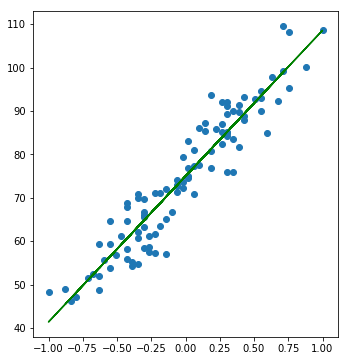

In [21]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, batch_gen=batch_shuffle, batch_size=10, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [21]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [22]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [ 1.  1.  1.]


In [23]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 loss_train: 10018.74710491 + 0.00000000 = 10018.74710491 loss_val = 10018.74710491
epoch:  200/2000 loss_train: 6.45438183 + 0.00000000 = 6.45438183 loss_val = 6.45438183
epoch:  400/2000 loss_train: 3.92489040 + 0.00000000 = 3.92489040 loss_val = 3.92489040
epoch:  600/2000 loss_train: 3.21620619 + 0.00000000 = 3.21620619 loss_val = 3.21620619
epoch:  800/2000 loss_train: 2.99546423 + 0.00000000 = 2.99546423 loss_val = 2.99546423
epoch: 1000/2000 loss_train: 2.91877848 + 0.00000000 = 2.91877848 loss_val = 2.91877848
epoch: 1200/2000 loss_train: 2.88958972 + 0.00000000 = 2.88958972 loss_val = 2.88958972
epoch: 1400/2000 loss_train: 2.87774539 + 0.00000000 = 2.87774539 loss_val = 2.87774539
epoch: 1600/2000 loss_train: 2.87274604 + 0.00000000 = 2.87274604 loss_val = 2.87274604
epoch: 1800/2000 loss_train: 2.87058824 + 0.00000000 = 2.87058824 loss_val = 2.87058824
epoch: 2000/2000 loss_train: 2.86964560 + 0.00000000 = 2.86964560 loss_val = 2.86964560
[[  8.93772  13.9760

### Regressão Quadrática

In [24]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [25]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/3000 loss_train: 931.41299728 + 0.00000000 = 931.41299728 loss_val = 931.41299728
epoch:  300/3000 loss_train: 23.05589550 + 0.00000000 = 23.05589550 loss_val = 23.05589550
epoch:  600/3000 loss_train: 32.94695213 + 0.00000000 = 32.94695213 loss_val = 32.94695213
epoch:  900/3000 loss_train: 17.31484887 + 0.00000000 = 17.31484887 loss_val = 17.31484887
epoch: 1200/3000 loss_train: 17.06053002 + 0.00000000 = 17.06053002 loss_val = 17.06053002
epoch: 1500/3000 loss_train: 16.92105744 + 0.00000000 = 16.92105744 loss_val = 16.92105744
epoch: 1800/3000 loss_train: 16.66972309 + 0.00000000 = 16.66972309 loss_val = 16.66972309
epoch: 2100/3000 loss_train: 16.57188789 + 0.00000000 = 16.57188789 loss_val = 16.57188789
epoch: 2400/3000 loss_train: 16.41143716 + 0.00000000 = 16.41143716 loss_val = 16.41143716
epoch: 2700/3000 loss_train: 16.28198781 + 0.00000000 = 16.28198781 loss_val = 16.28198781
epoch: 3000/3000 loss_train: 16.09452942 + 0.00000000 = 16.09452942 loss_val = 16.09452

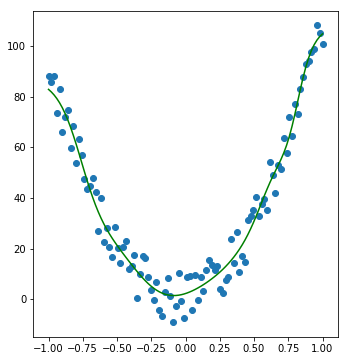

In [26]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=3000, verbose=300)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [27]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [28]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/1000 loss_train: 56.02956333 + 0.00000000 = 56.02956333 loss_val = 56.02956333
epoch:  100/1000 loss_train: 29.16795564 + 0.00000000 = 29.16795564 loss_val = 29.16795564
epoch:  200/1000 loss_train: 14.81041277 + 0.00000000 = 14.81041277 loss_val = 14.81041277
epoch:  300/1000 loss_train: 8.03711846 + 0.00000000 = 8.03711846 loss_val = 8.03711846
epoch:  400/1000 loss_train: 5.17479482 + 0.00000000 = 5.17479482 loss_val = 5.17479482
epoch:  500/1000 loss_train: 3.90255820 + 0.00000000 = 3.90255820 loss_val = 3.90255820
epoch:  600/1000 loss_train: 3.23936982 + 0.00000000 = 3.23936982 loss_val = 3.23936982
epoch:  700/1000 loss_train: 2.81371127 + 0.00000000 = 2.81371127 loss_val = 2.81371127
epoch:  800/1000 loss_train: 2.49736696 + 0.00000000 = 2.49736696 loss_val = 2.49736696
epoch:  900/1000 loss_train: 2.25693256 + 0.00000000 = 2.25693256 loss_val = 2.25693256
epoch: 1000/1000 loss_train: 2.07132900 + 0.00000000 = 2.07132900 loss_val = 2.07132900


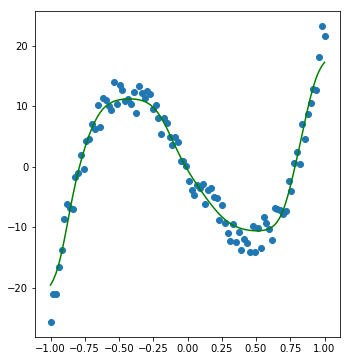

In [29]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [30]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [31]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/1000 loss_train: 0.08044004 + 0.00000000 = 0.08044004 loss_val = 0.08044004
epoch:  100/1000 loss_train: 0.01934009 + 0.00000000 = 0.01934009 loss_val = 0.01934009
epoch:  200/1000 loss_train: 0.01781998 + 0.00000000 = 0.01781998 loss_val = 0.01781998
epoch:  300/1000 loss_train: 0.01692354 + 0.00000000 = 0.01692354 loss_val = 0.01692354
epoch:  400/1000 loss_train: 0.01630976 + 0.00000000 = 0.01630976 loss_val = 0.01630976
epoch:  500/1000 loss_train: 0.01597796 + 0.00000000 = 0.01597796 loss_val = 0.01597796
epoch:  600/1000 loss_train: 0.01578356 + 0.00000000 = 0.01578356 loss_val = 0.01578356
epoch:  700/1000 loss_train: 0.01564666 + 0.00000000 = 0.01564666 loss_val = 0.01564666
epoch:  800/1000 loss_train: 0.01554062 + 0.00000000 = 0.01554062 loss_val = 0.01554062
epoch:  900/1000 loss_train: 0.01545435 + 0.00000000 = 0.01545435 loss_val = 0.01545435
epoch: 1000/1000 loss_train: 0.01538208 + 0.00000000 = 0.01538208 loss_val = 0.01538208


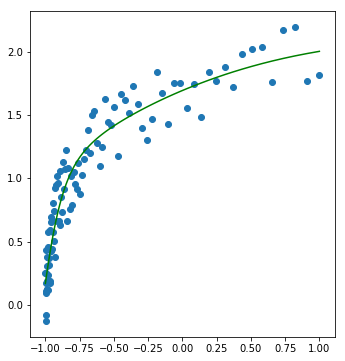

In [32]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [33]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [34]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/1000 loss_train: 1268.82386329 + 0.00000000 = 1268.82386329 loss_val = 1268.82386329
epoch:  100/1000 loss_train: 23.50681350 + 0.00000000 = 23.50681350 loss_val = 23.50681350
epoch:  200/1000 loss_train: 17.49338200 + 0.00000000 = 17.49338200 loss_val = 17.49338200
epoch:  300/1000 loss_train: 16.68933664 + 0.00000000 = 16.68933664 loss_val = 16.68933664
epoch:  400/1000 loss_train: 16.50000260 + 0.00000000 = 16.50000260 loss_val = 16.50000260
epoch:  500/1000 loss_train: 16.44196639 + 0.00000000 = 16.44196639 loss_val = 16.44196639
epoch:  600/1000 loss_train: 16.38856376 + 0.00000000 = 16.38856376 loss_val = 16.38856376
epoch:  700/1000 loss_train: 16.34328185 + 0.00000000 = 16.34328185 loss_val = 16.34328185
epoch:  800/1000 loss_train: 16.31056113 + 0.00000000 = 16.31056113 loss_val = 16.31056113
epoch:  900/1000 loss_train: 16.28583699 + 0.00000000 = 16.28583699 loss_val = 16.28583699
epoch: 1000/1000 loss_train: 16.26424967 + 0.00000000 = 16.26424967 loss_val = 16.26

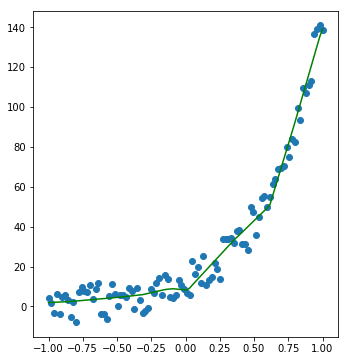

In [35]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [36]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/1000 loss_train: 0.89534698 + 0.02032667 = 0.91567365 loss_val = 0.89534698
epoch:  100/1000 loss_train: 0.16983495 + 0.06626148 = 0.23609643 loss_val = 0.16983495
epoch:  200/1000 loss_train: 0.11123838 + 0.08887483 = 0.20011321 loss_val = 0.11123838
epoch:  300/1000 loss_train: 0.08776488 + 0.10136435 = 0.18912924 loss_val = 0.08776488
epoch:  400/1000 loss_train: 0.07547765 + 0.10925207 = 0.18472972 loss_val = 0.07547765
epoch:  500/1000 loss_train: 0.06815154 + 0.11457010 = 0.18272164 loss_val = 0.06815154
epoch:  600/1000 loss_train: 0.06343616 + 0.11829627 = 0.18173242 loss_val = 0.06343616
epoch:  700/1000 loss_train: 0.06024817 + 0.12097255 = 0.18122072 loss_val = 0.06024817
epoch:  800/1000 loss_train: 0.05801981 + 0.12292733 = 0.18094714 loss_val = 0.05801981
epoch:  900/1000 loss_train: 0.05642539 + 0.12437205 = 0.18079745 loss_val = 0.05642539
epoch: 1000/1000 loss_train: 0.05526529 + 0.12544889 = 0.18071418 loss_val = 0.05526529
[[ 5.01796  5.01796]] [[-7.89223

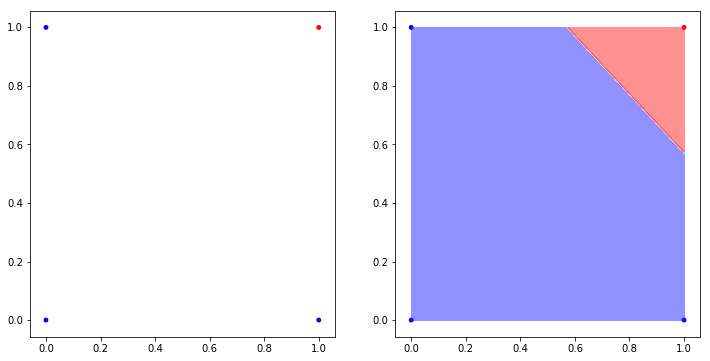

In [37]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear, reg_func=l1_regularization, reg_strength=0.05))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights, nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, cmap='bwr')

### Porta XOR

In [38]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/1000 loss_train: 0.71885835 + 0.00000000 = 0.71885835 loss_val = 0.71885835
epoch:  100/1000 loss_train: 0.65398611 + 0.00000000 = 0.65398611 loss_val = 0.65398611
epoch:  200/1000 loss_train: 0.49223862 + 0.00000000 = 0.49223862 loss_val = 0.49223862
epoch:  300/1000 loss_train: 0.14398618 + 0.00000000 = 0.14398618 loss_val = 0.14398618
epoch:  400/1000 loss_train: 0.06397110 + 0.00000000 = 0.06397110 loss_val = 0.06397110
epoch:  500/1000 loss_train: 0.03980210 + 0.00000000 = 0.03980210 loss_val = 0.03980210
epoch:  600/1000 loss_train: 0.02859892 + 0.00000000 = 0.02859892 loss_val = 0.02859892
epoch:  700/1000 loss_train: 0.02221644 + 0.00000000 = 0.02221644 loss_val = 0.02221644
epoch:  800/1000 loss_train: 0.01811862 + 0.00000000 = 0.01811862 loss_val = 0.01811862
epoch:  900/1000 loss_train: 0.01527447 + 0.00000000 = 0.01527447 loss_val = 0.01527447
epoch: 1000/1000 loss_train: 0.01318933 + 0.00000000 = 0.01318933 loss_val = 0.01318933
Predições:
[[-4.34953]
 [ 4.4102

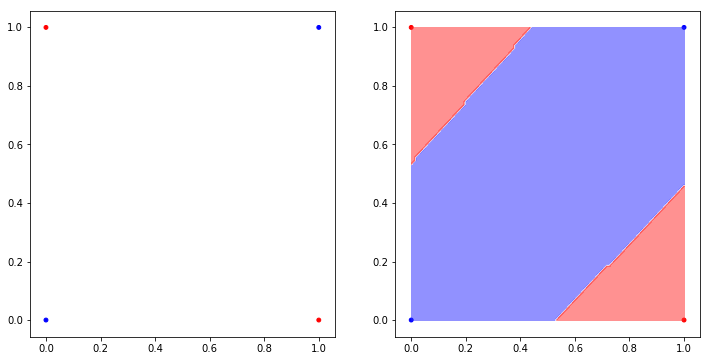

In [39]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, cmap='bwr')

### 2 Clusters

In [40]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 loss_train: 1.81936632 + 0.00000000 = 1.81936632 loss_val = 1.81936632
epoch: 1000/5000 loss_train: 0.00464577 + 0.00000000 = 0.00464577 loss_val = 0.00464577
epoch: 2000/5000 loss_train: 0.00357236 + 0.00000000 = 0.00357236 loss_val = 0.00357236
epoch: 3000/5000 loss_train: 0.00298124 + 0.00000000 = 0.00298124 loss_val = 0.00298124
epoch: 4000/5000 loss_train: 0.00259287 + 0.00000000 = 0.00259287 loss_val = 0.00259287
epoch: 5000/5000 loss_train: 0.00231232 + 0.00000000 = 0.00231232 loss_val = 0.00231232
Acurácia: 100.00%


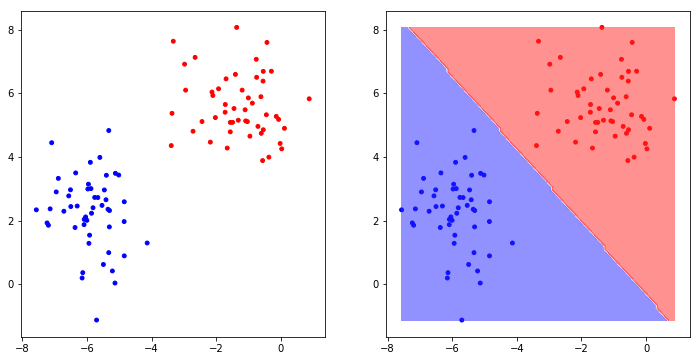

In [41]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

In [42]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/500 loss_train: 2.41565407 + 0.00000000 = 2.41565407 loss_val = 2.41565407
epoch:  100/500 loss_train: 0.07778115 + 0.00000000 = 0.07778115 loss_val = 0.07778115
epoch:  200/500 loss_train: 0.04604439 + 0.00000000 = 0.04604439 loss_val = 0.04604439
epoch:  300/500 loss_train: 0.03232045 + 0.00000000 = 0.03232045 loss_val = 0.03232045
epoch:  400/500 loss_train: 0.02478517 + 0.00000000 = 0.02478517 loss_val = 0.02478517
epoch:  500/500 loss_train: 0.02005445 + 0.00000000 = 0.02005445 loss_val = 0.02005445
Acurácia: 100.00%


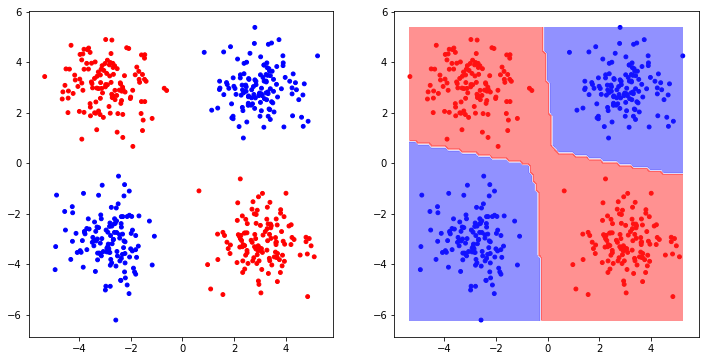

In [44]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=500, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

In [45]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/1000 loss_train: 1.26773777 + 0.00000000 = 1.26773777 loss_val = 1.26773777
epoch:  100/1000 loss_train: 0.14888782 + 0.00000000 = 0.14888782 loss_val = 0.14888782
epoch:  200/1000 loss_train: 0.07053128 + 0.00000000 = 0.07053128 loss_val = 0.07053128
epoch:  300/1000 loss_train: 0.04586654 + 0.00000000 = 0.04586654 loss_val = 0.04586654
epoch:  400/1000 loss_train: 0.03382813 + 0.00000000 = 0.03382813 loss_val = 0.03382813
epoch:  500/1000 loss_train: 0.02676286 + 0.00000000 = 0.02676286 loss_val = 0.02676286
epoch:  600/1000 loss_train: 0.02211264 + 0.00000000 = 0.02211264 loss_val = 0.02211264
epoch:  700/1000 loss_train: 0.01880860 + 0.00000000 = 0.01880860 loss_val = 0.01880860
epoch:  800/1000 loss_train: 0.01634903 + 0.00000000 = 0.01634903 loss_val = 0.01634903
epoch:  900/1000 loss_train: 0.01444166 + 0.00000000 = 0.01444166 loss_val = 0.01444166
epoch: 1000/1000 loss_train: 0.01292132 + 0.00000000 = 0.01292132 loss_val = 0.01292132
Acurácia: 100.00%


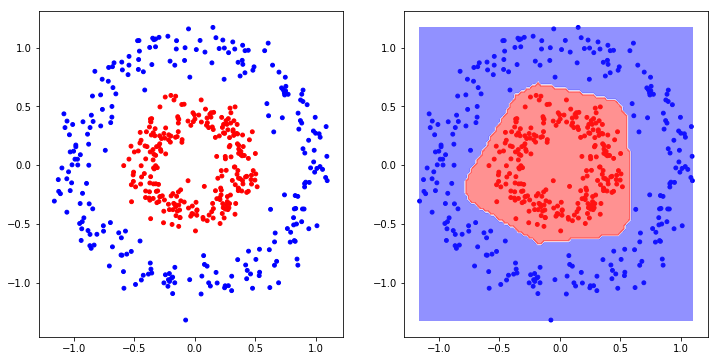

In [46]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

In [47]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/2000 loss_train: 1.13315346 + 0.00000000 = 1.13315346 loss_val = 1.13315346
epoch:  200/2000 loss_train: 0.29014494 + 0.00000000 = 0.29014494 loss_val = 0.29014494
epoch:  400/2000 loss_train: 0.16474963 + 0.00000000 = 0.16474963 loss_val = 0.16474963
epoch:  600/2000 loss_train: 0.09041644 + 0.00000000 = 0.09041644 loss_val = 0.09041644
epoch:  800/2000 loss_train: 0.07076948 + 0.00000000 = 0.07076948 loss_val = 0.07076948
epoch: 1000/2000 loss_train: 0.06275274 + 0.00000000 = 0.06275274 loss_val = 0.06275274
epoch: 1200/2000 loss_train: 0.05859111 + 0.00000000 = 0.05859111 loss_val = 0.05859111
epoch: 1400/2000 loss_train: 0.05613312 + 0.00000000 = 0.05613312 loss_val = 0.05613312
epoch: 1600/2000 loss_train: 0.05456209 + 0.00000000 = 0.05456209 loss_val = 0.05456209
epoch: 1800/2000 loss_train: 0.05349936 + 0.00000000 = 0.05349936 loss_val = 0.05349936
epoch: 2000/2000 loss_train: 0.05274732 + 0.00000000 = 0.05274732 loss_val = 0.05274732
Acurácia: 97.00%


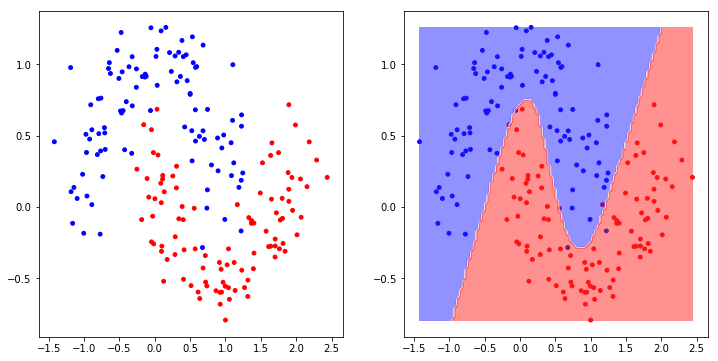

In [48]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=tanh))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=2000, verbose=200)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

In [49]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/5000 loss_train: 1.62713296 + 0.00000000 = 1.62713296 loss_val = 1.62713296
epoch:  500/5000 loss_train: 0.14693196 + 0.00000000 = 0.14693196 loss_val = 0.14693196
epoch: 1000/5000 loss_train: 0.03786165 + 0.00000000 = 0.03786165 loss_val = 0.03786165
epoch: 1500/5000 loss_train: 0.01896228 + 0.00000000 = 0.01896228 loss_val = 0.01896228
epoch: 2000/5000 loss_train: 0.06474966 + 0.00000000 = 0.06474966 loss_val = 0.06474966
epoch: 2500/5000 loss_train: 0.01282427 + 0.00000000 = 0.01282427 loss_val = 0.01282427
epoch: 3000/5000 loss_train: 0.00936096 + 0.00000000 = 0.00936096 loss_val = 0.00936096
epoch: 3500/5000 loss_train: 0.00962722 + 0.00000000 = 0.00962722 loss_val = 0.00962722
epoch: 4000/5000 loss_train: 0.00848831 + 0.00000000 = 0.00848831 loss_val = 0.00848831
epoch: 4500/5000 loss_train: 0.00804061 + 0.00000000 = 0.00804061 loss_val = 0.00804061
epoch: 5000/5000 loss_train: 0.00836681 + 0.00000000 = 0.00836681 loss_val = 0.00836681
Acurácia: 99.50%


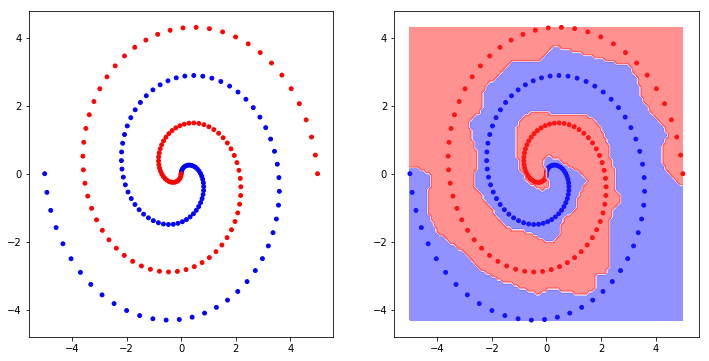

In [50]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh, dropout_prob=0.25))
nn.layers.append(Layer(input_dim=20, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=500)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

In [51]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(300, 2) (300, 1)


In [52]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]


epoch:    0/1000 loss_train: 2.79331073 + 0.00064153 = 2.79395226 loss_val = 2.79331073
epoch:  100/1000 loss_train: 0.11216499 + 0.00930557 = 0.12147057 loss_val = 0.11216499
epoch:  200/1000 loss_train: 0.04798151 + 0.00903024 = 0.05701176 loss_val = 0.04798151
epoch:  300/1000 loss_train: 0.02952564 + 0.00866890 = 0.03819454 loss_val = 0.02952564
epoch:  400/1000 loss_train: 0.02116545 + 0.00829503 = 0.02946048 loss_val = 0.02116545
epoch:  500/1000 loss_train: 0.01646682 + 0.00792841 = 0.02439522 loss_val = 0.01646682
epoch:  600/1000 loss_train: 0.01347763 + 0.00757692 = 0.02105455 loss_val = 0.01347763
epoch:  700/1000 loss_train: 0.01141734 + 0.00724402 = 0.01866135 loss_val = 0.01141734
epoch:  800/1000 loss_train: 0.00991559 + 0.00693109 = 0.01684668 loss_val = 0.00991559
epoch:  900/1000 loss_train: 0.00877489 + 0.00663846 = 0.01541335 loss_val = 0.00877489
epoch: 1000/1000 loss_train: 0.00788060 + 0.00636582 = 0.01424642 loss_val = 0.00788060
[[ 0.46508 -4.71013]
 [ 2.0517  

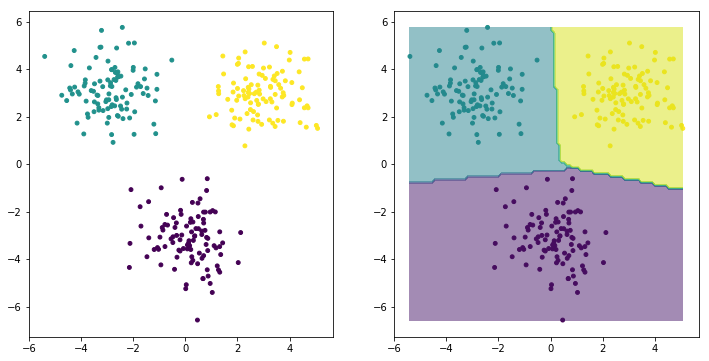

In [53]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu, reg_func=l2_regularization, reg_strength=0.1))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=0.1))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

for layer in nn.layers:
    print(layer.weights)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

In [54]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(400, 2) (400, 1)


In [55]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


epoch:    0/1000 loss_train: 2.64040089 + 0.00000000 = 2.64040089 loss_val = 2.64040089
epoch:  100/1000 loss_train: 0.18096282 + 0.00000000 = 0.18096282 loss_val = 0.18096282
epoch:  200/1000 loss_train: 0.12384504 + 0.00000000 = 0.12384504 loss_val = 0.12384504
epoch:  300/1000 loss_train: 0.10302647 + 0.00000000 = 0.10302647 loss_val = 0.10302647
epoch:  400/1000 loss_train: 0.09372606 + 0.00000000 = 0.09372606 loss_val = 0.09372606
epoch:  500/1000 loss_train: 0.08837548 + 0.00000000 = 0.08837548 loss_val = 0.08837548
epoch:  600/1000 loss_train: 0.08488199 + 0.00000000 = 0.08488199 loss_val = 0.08488199
epoch:  700/1000 loss_train: 0.08242920 + 0.00000000 = 0.08242920 loss_val = 0.08242920
epoch:  800/1000 loss_train: 0.08065121 + 0.00000000 = 0.08065121 loss_val = 0.08065121
epoch:  900/1000 loss_train: 0.07930743 + 0.00000000 = 0.07930743 loss_val = 0.07930743
epoch: 1000/1000 loss_train: 0.07825560 + 0.00000000 = 0.07825560 loss_val = 0.07825560
Acurácia: 97.00%


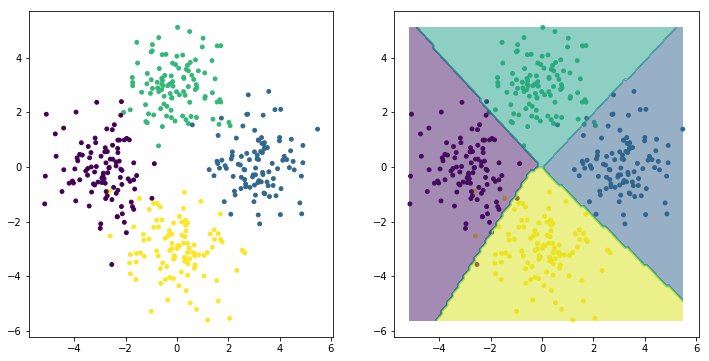

In [56]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

In [57]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


In [58]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


epoch:    0/2000 loss_train: 5.03263788 + 0.00000000 = 5.03263788 loss_val = 5.03263788
epoch:  200/2000 loss_train: 0.83257991 + 0.00000000 = 0.83257991 loss_val = 0.83257991
epoch:  400/2000 loss_train: 0.65065945 + 0.00000000 = 0.65065945 loss_val = 0.65065945
epoch:  600/2000 loss_train: 0.50741787 + 0.00000000 = 0.50741787 loss_val = 0.50741787
epoch:  800/2000 loss_train: 0.34459062 + 0.00000000 = 0.34459062 loss_val = 0.34459062
epoch: 1000/2000 loss_train: 0.25833223 + 0.00000000 = 0.25833223 loss_val = 0.25833223
epoch: 1200/2000 loss_train: 0.19938358 + 0.00000000 = 0.19938358 loss_val = 0.19938358
epoch: 1400/2000 loss_train: 0.15331047 + 0.00000000 = 0.15331047 loss_val = 0.15331047
epoch: 1600/2000 loss_train: 0.12693314 + 0.00000000 = 0.12693314 loss_val = 0.12693314
epoch: 1800/2000 loss_train: 0.11029595 + 0.00000000 = 0.11029595 loss_val = 0.11029595
epoch: 2000/2000 loss_train: 0.09708692 + 0.00000000 = 0.09708692 loss_val = 0.09708692
Acurácia: 98.00%


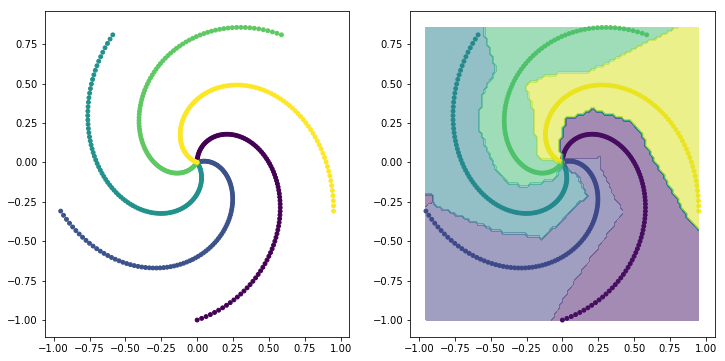

In [72]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [73]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


In [74]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


epoch:    0/1000 loss_train: 4.55748293 + 0.00000000 = 4.55748293 loss_val = 4.55748293
epoch:  100/1000 loss_train: 0.28752215 + 0.00000000 = 0.28752215 loss_val = 0.28752215
epoch:  200/1000 loss_train: 0.22523240 + 0.00000000 = 0.22523240 loss_val = 0.22523240
epoch:  300/1000 loss_train: 0.19842919 + 0.00000000 = 0.19842919 loss_val = 0.19842919
epoch:  400/1000 loss_train: 0.18264610 + 0.00000000 = 0.18264610 loss_val = 0.18264610
epoch:  500/1000 loss_train: 0.17300644 + 0.00000000 = 0.17300644 loss_val = 0.17300644
epoch:  600/1000 loss_train: 0.16629950 + 0.00000000 = 0.16629950 loss_val = 0.16629950
epoch:  700/1000 loss_train: 0.16166647 + 0.00000000 = 0.16166647 loss_val = 0.16166647
epoch:  800/1000 loss_train: 0.15762463 + 0.00000000 = 0.15762463 loss_val = 0.15762463
epoch:  900/1000 loss_train: 0.15436850 + 0.00000000 = 0.15436850 loss_val = 0.15436850
epoch: 1000/1000 loss_train: 0.15191996 + 0.00000000 = 0.15191996 loss_val = 0.15191996
Acurácia: 95.00%


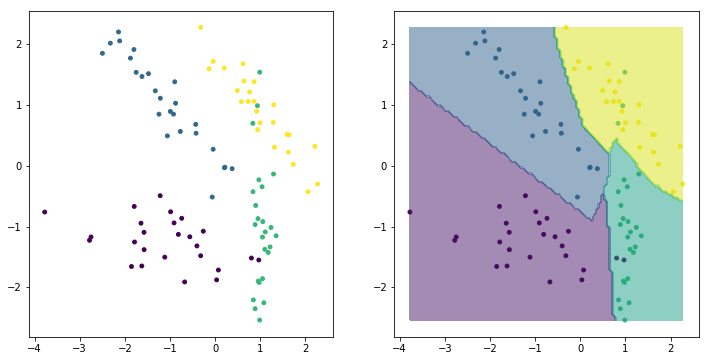

In [75]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [76]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [77]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


epoch:    0/2000 loss_train: 2.04459260 + 0.00000000 = 2.04459260 loss_val = 2.04459260
epoch:  200/2000 loss_train: 0.37602333 + 0.00000000 = 0.37602333 loss_val = 0.37602333
epoch:  400/2000 loss_train: 0.27606437 + 0.00000000 = 0.27606437 loss_val = 0.27606437
epoch:  600/2000 loss_train: 0.22669815 + 0.00000000 = 0.22669815 loss_val = 0.22669815
epoch:  800/2000 loss_train: 0.19612501 + 0.00000000 = 0.19612501 loss_val = 0.19612501
epoch: 1000/2000 loss_train: 0.17413545 + 0.00000000 = 0.17413545 loss_val = 0.17413545
epoch: 1200/2000 loss_train: 0.15839362 + 0.00000000 = 0.15839362 loss_val = 0.15839362
epoch: 1400/2000 loss_train: 0.14679511 + 0.00000000 = 0.14679511 loss_val = 0.14679511
epoch: 1600/2000 loss_train: 0.13788635 + 0.00000000 = 0.13788635 loss_val = 0.13788635
epoch: 1800/2000 loss_train: 0.13081024 + 0.00000000 = 0.13081024 loss_val = 0.13081024
epoch: 2000/2000 loss_train: 0.12504028 + 0.00000000 = 0.12504028 loss_val = 0.12504028
Acurácia: 96.00%


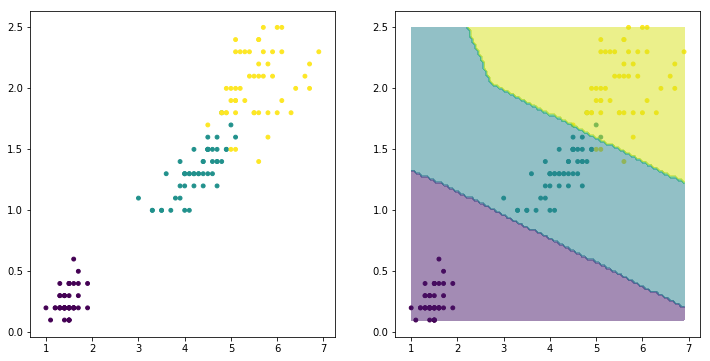

In [81]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)

__TODO__:
- evitar overflow das funções de ativação

```py
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)
```

__NOTAS__:

__Inicialização dos pesos__:
- mostrar a documentação das funções np.random.rand e np.random.randn para mostrar como gerar distribuições na faixa [-limit, limit] e com média zero e certo desvio-padrão.
- mostrar que os métodos de inicialização de pesos ones e random_uniform podem não ser adequados para alguns problemas, como o do espiral binário.

__Regularização__:
- mostrar que a regularização dos pesos nem sempre ajuda. Em alguns casos, como o espiral multiclasse, temos que definir a reg_strength muito pequena. Isto é, estamos dizendo que o valores dos pesos não podem influenciar no custo. Em outras palavras, isso é a mesma coisa que "desligar" a regularização.
- temos de ter muito cuidado ao fazer a checkagem do gradiente com regularização L1/L2. Muitas implementações esquecem de adicionar o custo da regularização na checkagem do gradiente. Isso pode fazer você pensar que a implementação está errada.

__Learning Rate Decay__:
- mostrar que a staircase_decay e exponential_decay tem praticamente a mesma fórmula, com exceção de decay_steps. Na própria documentação do Tensorflow, eles implementam as duas no mesmo método.